In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

xlsx = pd.ExcelFile('HomePriceIndex.xls')
df = pd.read_excel(xlsx, skiprows=6)

df.rename({'Date': 'Year',
           'Index': 'RealHomePriceIndex',
           'Index.1': 'RealBuildingCost',
          'Millions': 'Population',
          'Long Rate': 'LongRate'}, inplace=True, axis=1)
df = df[['Year', 'RealHomePriceIndex', 'RealBuildingCost', 'Population', 'LongRate']]
df.head()

,Year,RealHomePriceIndex,RealBuildingCost,Population,LongRate
0,1890.0,100.000000,51.362340,63.056,3.42
1,1891.0,88.011791,47.266163,64.361,3.62
2,1892.0,95.421736,52.048155,65.666,3.6
3,1893.0,92.297385,44.673332,66.970,3.75
4,1894.0,123.980483,57.263434,68.275,3.7


Let's check out datatypes and change objects to numeric.

In [16]:
df.dtypes

Year                  float64
RealHomePriceIndex    float64
RealBuildingCost      float64
Population            float64
LongRate               object
dtype: object

In [17]:
df['LongRate'] = pd.to_numeric(df['LongRate'], errors='coerce').dropna()

The major problem with this dataset is that it's a time series where the frequency changes in the middle of the set. So around 1953 the frequencies switches from annual to monthly all the way to 2018.

Because this problem concerns just the 'Year' and 'RealHomePriceIndex' variables we will separate them out, resample and aggregat using the mean and put the two dataframes together into one that we can work on.

In [18]:
df_2 = df[['Year', 'RealHomePriceIndex']]
df_2.drop([851,852,853], inplace=True)

# Resample 'Year' and make it into an index

df_2['Year'].loc[0:62] = pd.date_range('1890', periods=63, freq='A')
df_2['Year'].loc[63:] = pd.date_range('1953', periods=788, freq='M')

df_2.index = df_2.Year
df_2.drop('Year', inplace=True, axis=1)

df_2_bottom = df_2['1953-01-31':].resample('A').mean()
df_2_bottom = df_2_bottom.astype('int')

df_2 = df_2.loc['1890-12-31': '1952-12-31']
df_2 = df_2.append(df_2_bottom)

df_2.index

/Users/sammylee/miniconda3/envs/datascience/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/sammylee/miniconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sammylee/miniconda3/envs/datascience/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, val

DatetimeIndex(['1890-12-31', '1891-12-31', '1892-12-31', '1893-12-31', '1894-12-31', '1895-12-31', '1896-12-31', '1897-12-31', '1898-12-31', '1899-12-31',
               ...
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31'], dtype='datetime64[ns]', name='Year', length=129, freq=None)

Now we clean up the old df DataFrame that we separated 'RealHomePriceIndex' from

In [19]:
df.drop(['Year', 'RealHomePriceIndex'], inplace=True, axis=1)  # Drop these because we already have df_2
df.dropna(inplace=True)  # Drop NaN values

df_2 = df_2.loc['1890-12-31':'2015-12-31']  # Truncate by 3 rows to make it even with the rest of the DataFrame

df.index = df_2.index

# Finally add df_2 to df
df['RealHomePriceIndex'] = df_2['RealHomePriceIndex']
df.head()

,RealBuildingCost,Population,LongRate,RealHomePriceIndex
Year,,,,
1890-12-31,51.362340,63.056,3.42,100.000000
1891-12-31,47.266163,64.361,3.62,88.011791
1892-12-31,52.048155,65.666,3.60,95.421736
1893-12-31,44.673332,66.970,3.75,92.297385
1894-12-31,57.263434,68.275,3.70,123.980483


In [20]:
df.describe()

,RealBuildingCost,Population,LongRate,RealHomePriceIndex
count,126.000000,126.000000,126.000000,126.000000
mean,64.925479,173.870532,4.637619,105.783937
std,19.127443,76.600732,2.396380,25.226972
min,32.805185,63.056000,1.880000,65.614308
25%,47.983188,108.915750,3.157500,88.046034
50%,62.319684,158.259500,3.865000,106.252948
75%,81.445344,235.878750,5.437500,114.000000
max,100.568840,321.704000,14.590000,194.000000


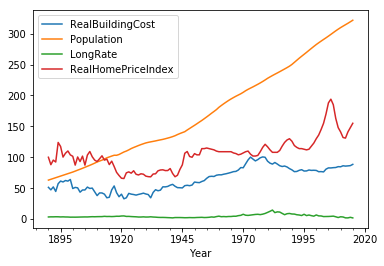

In [21]:
df.plot()

Let's plot the data using fivethirtyeight's style

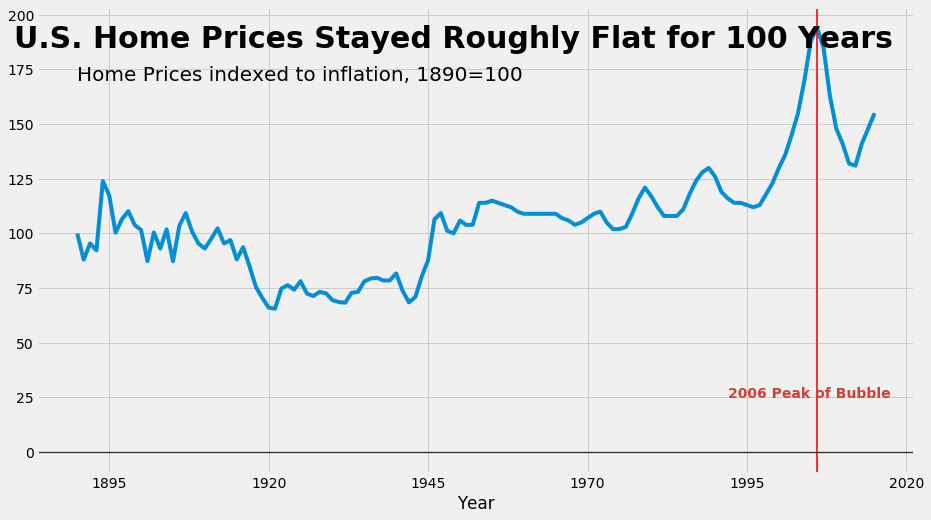

In [24]:
plt.style.use('fivethirtyeight')

ax = df.RealHomePriceIndex.plot.line(x=df.index, y=df.RealHomePriceIndex, legend=False, figsize=(14,8));

ax.axvline(x='2006', color='red', linewidth=2, alpha=0.8)
ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.8)

# If index is datetimerange, it has to be in quotes for the plot to work

ax.text(x='1880', y=185, s="U.S. Home Prices Stayed Roughly Flat for 100 Years",
       fontsize=30, fontweight='bold');

ax.text(x='1890', y=170, s="Home Prices indexed to inflation, 1890=100",
       fontsize=20);

ax.text(x='1992', y=25, s="2006 Peak of Bubble",
       fontweight='bold', color='#CB4335');